In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('../plotting.mplstyle')

In [2]:
import cymetric as cym
from cymetric import filters
from cymetric import graphs
from cymetric import timeseries
from cymetric import tools
import graphviz
import sqlite3

In [3]:
import importlib.util

# Specify the path relative to the current notebook's directory
dep_spec = importlib.util.spec_from_file_location('deployment', '../scripts/deployment.py')
dep = importlib.util.module_from_spec(dep_spec)
dep_spec.loader.exec_module(dep)

tran_spec = importlib.util.spec_from_file_location('fuel_transactions', '../scripts/fuel_transactions.py')
tran = importlib.util.module_from_spec(tran_spec)
tran_spec.loader.exec_module(tran)

waste_spec = importlib.util.spec_from_file_location('waste', '../scripts/waste.py')
waste = importlib.util.module_from_spec(waste_spec)
waste_spec.loader.exec_module(waste)

# Cymetric

In [5]:
db = cym.dbopen('cycamore_me_test_out.sqlite')
evaler = cym.Evaluator(db, write=False)

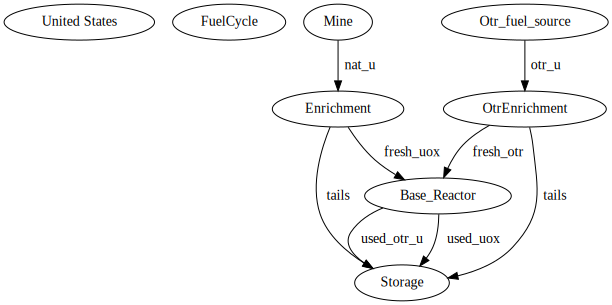

In [6]:
graphs.flow_graph(evaler, label='com')

In [7]:
reactor_list = ['Base_Reactor']
time = evaler.eval('TimeList')

Text(0, 0.5, 'Facilities [#]')

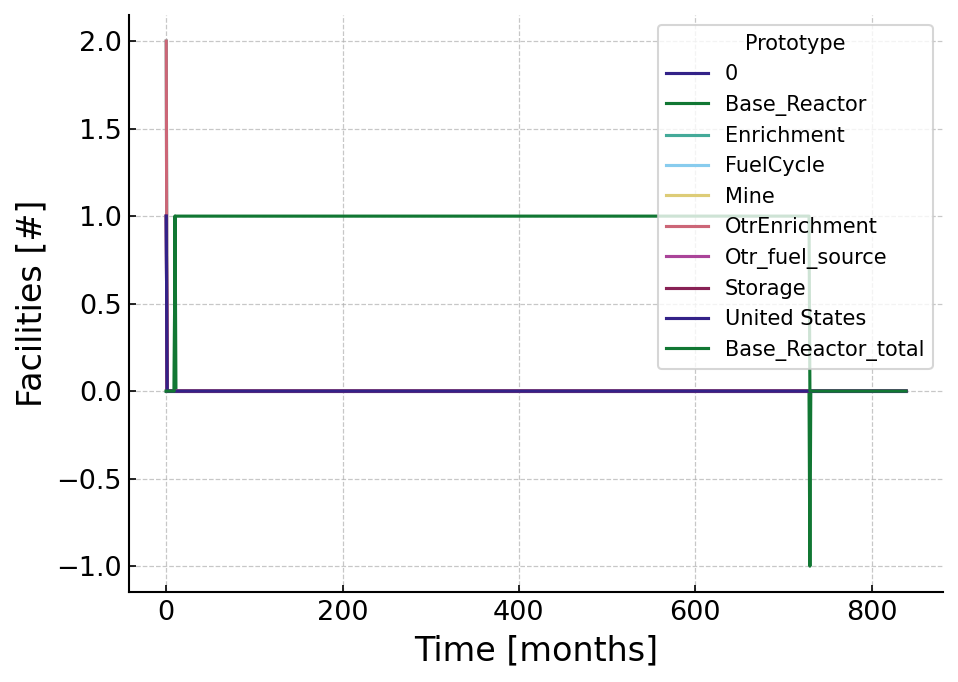

In [8]:
commission_by_prototype, commission_df = dep.comm_by_prototype(evaler, time)

decommission_by_prototype = dep.decom_by_prototype(evaler, commission_df, time)

deployment_by_prototype = dep.depl_by_prototype(commission_by_prototype, decommission_by_prototype, reactor_list)

deployment_by_prototype = dep.total_reactor(deployment_by_prototype, reactor_list)

deployment_by_prototype.plot(use_index=True)
plt.xlabel('Time [months]')
plt.ylabel('Facilities [#]')

Text(0, 0.5, 'Reactors [#]')

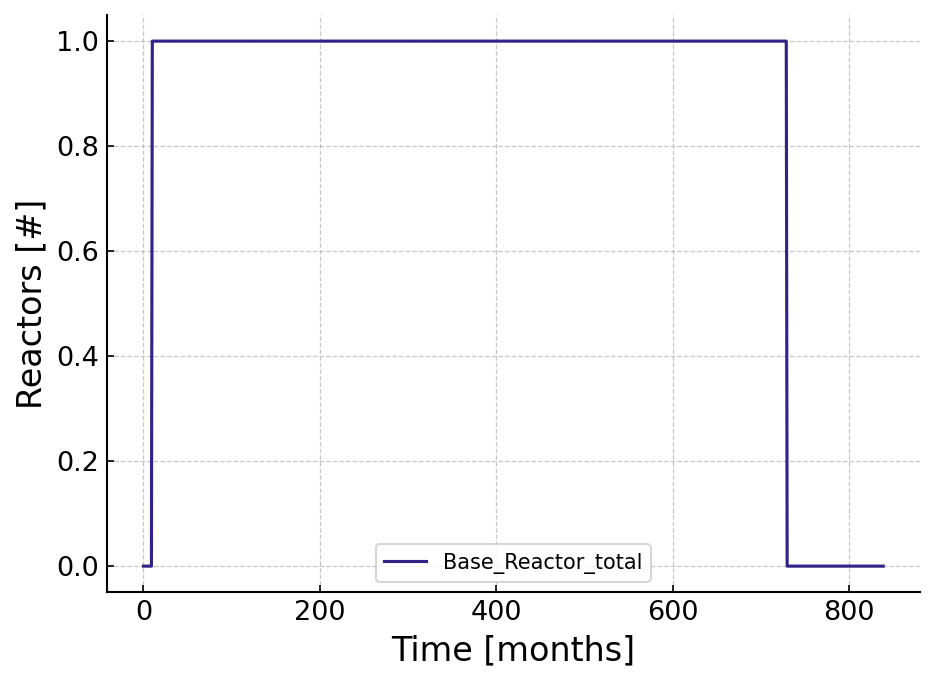

In [9]:
deployment_by_prototype.plot(y='Base_Reactor_total', use_index=True)
plt.xlabel('Time [months]')
plt.ylabel('Reactors [#]')

In [10]:
repository_waste = timeseries.transactions(evaler=evaler, receivers=['Storage'])

Text(0, 0.5, 'Mass of waste [kg]')

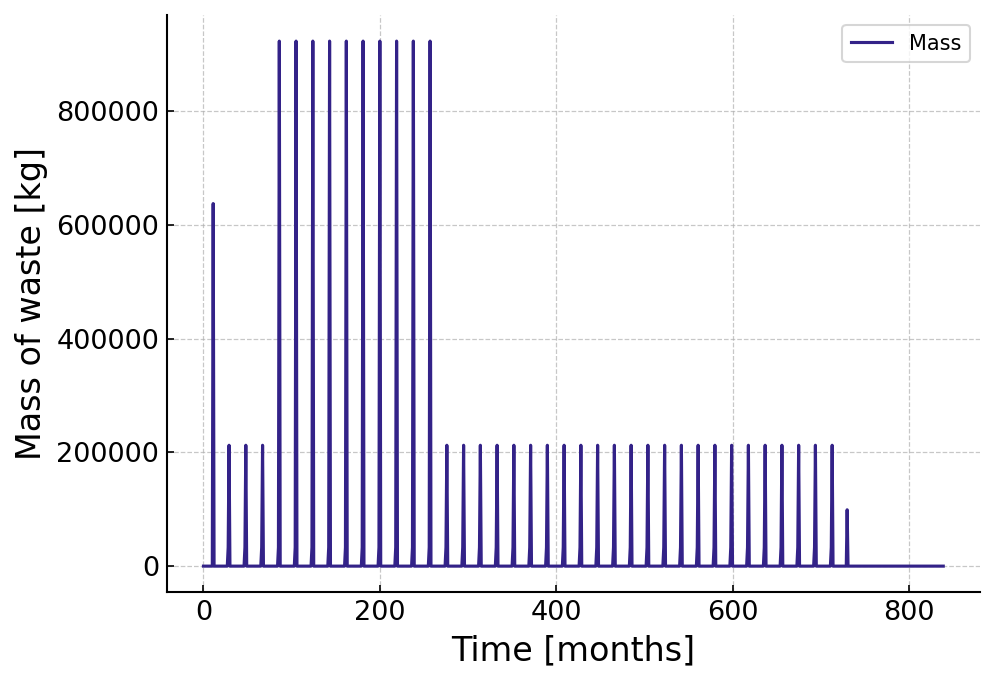

In [11]:
repository_waste.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

Text(0, 0.5, 'Mass of waste [kg]')

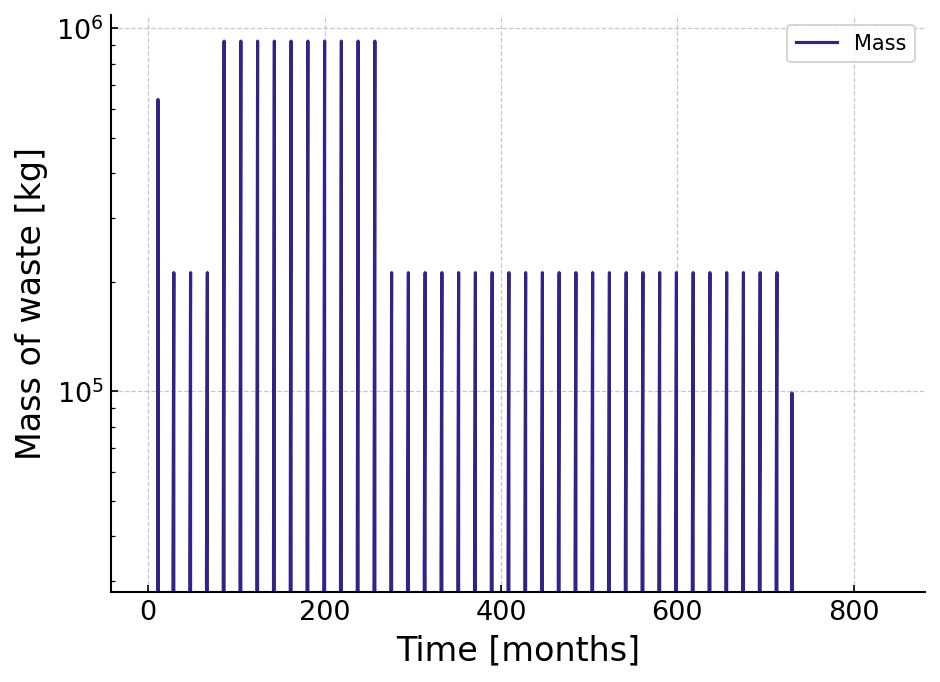

In [12]:
repository_waste.plot(x='Time', logy=True)
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

Text(0, 0.5, 'Mass of waste [kg]')

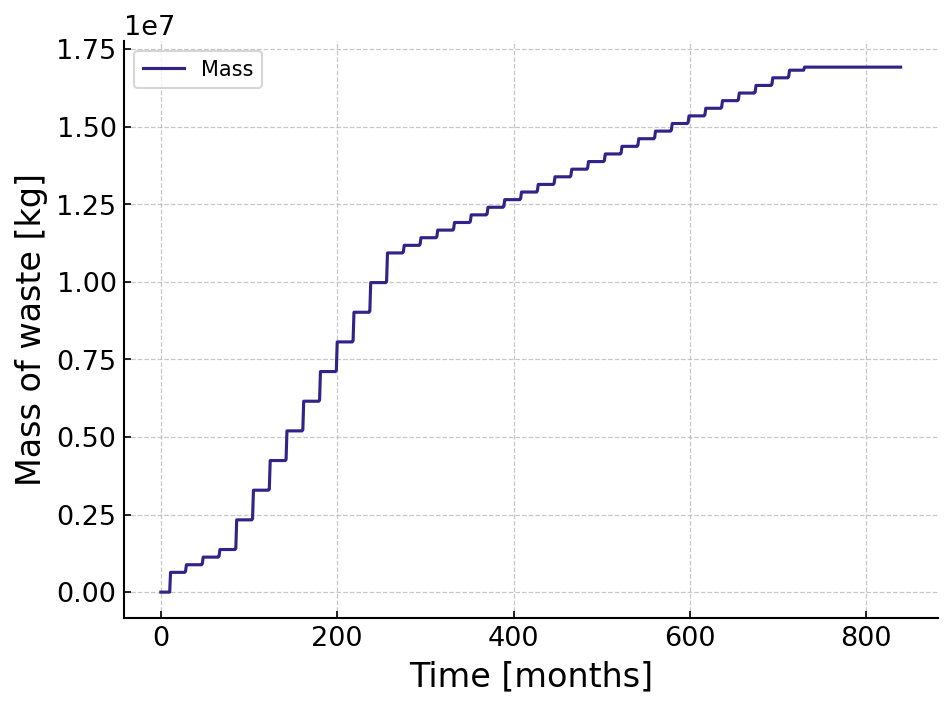

In [13]:
repository_waste['Mass'] = repository_waste['Mass'].cumsum()
repository_waste.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

In [14]:
reactor_input = timeseries.transactions(evaler=evaler, receivers=['Base_Reactor'])

In [17]:
transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
transactions = transactions.rename(columns={'TimeCreated':'Time'})

fuels = ['uox','otr_u']

transactions = tran.used_fuel_transactions(transactions, fuels)
transactions = tran.fresh_fuel_transactions(transactions, fuels)
transactions = tran.total_used_fr_fuel(transactions, fuels)

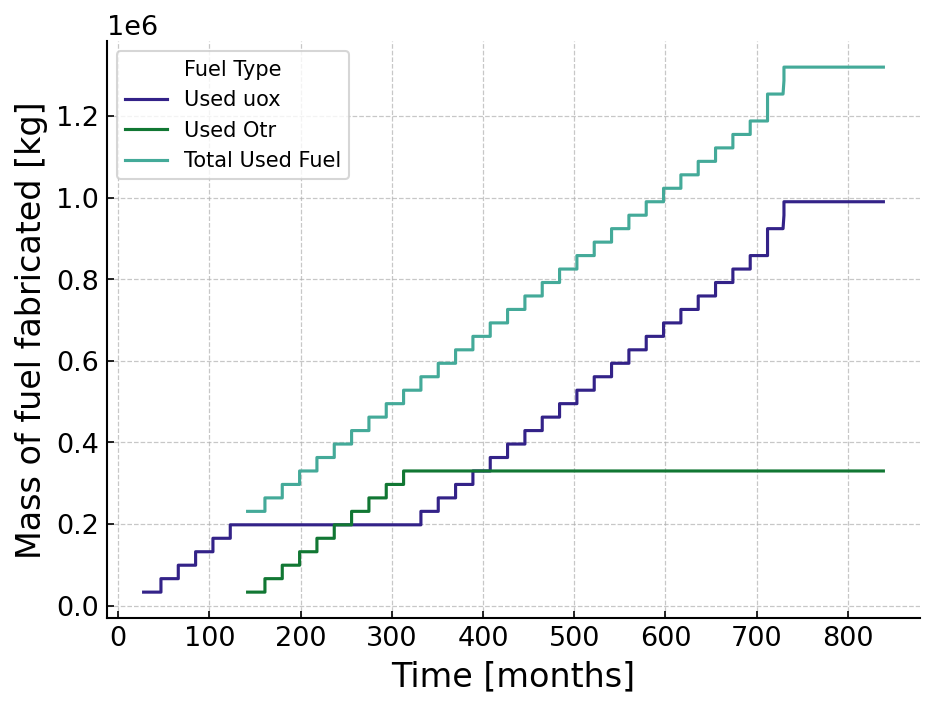

In [18]:
# Plotting cumulative fuel sent to reactors at each time step
transactions[['Time', 'used_uox_total', 'used_otr_u_total', 'total_used_fuel']].plot(x = 'Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of fuel fabricated [kg]')

legend = plt.legend()
legend.get_texts()[0].set_text('Used uox')
legend.get_texts()[1].set_text('Used Otr')
legend.get_texts()[2].set_text('Total Used Fuel')
legend.set_title('Fuel Type')

Text(0, 0.5, 'Mass of U235 [kg]')

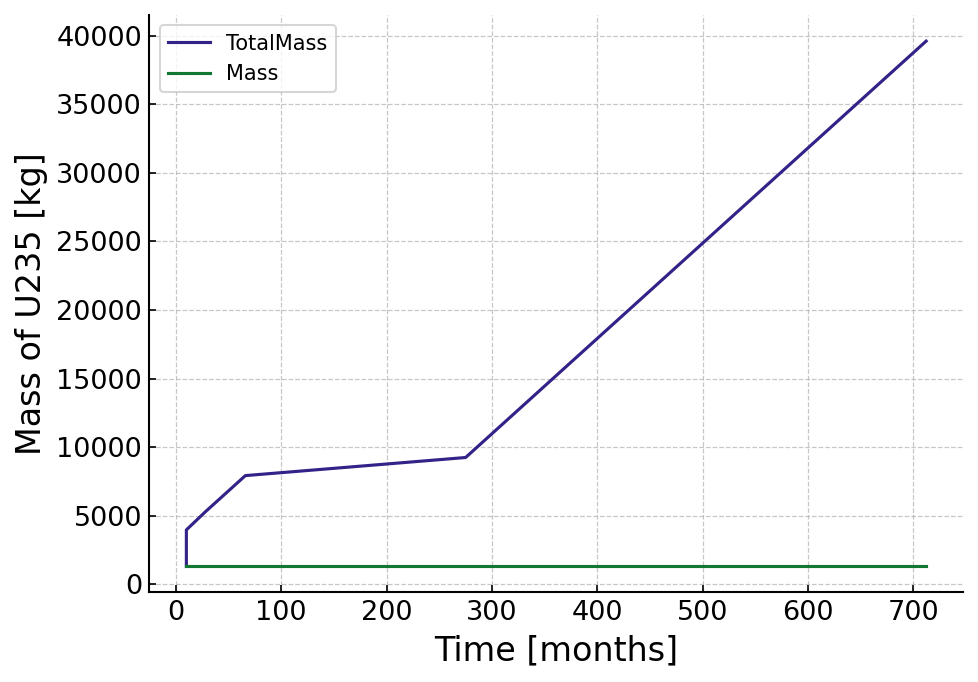

In [19]:
U235_mass = waste.transactions_nuc_built_in(evaler=evaler, receivers=['Base_Reactor'], commodities=['fresh_uox'], nucs=['92235'])

U235_mass['TotalMass'] = U235_mass['Mass'].cumsum()
U235_mass[['Time','TotalMass','Mass']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of U235 [kg]')

Text(0, 0.5, 'Mass of Pu239 [kg]')

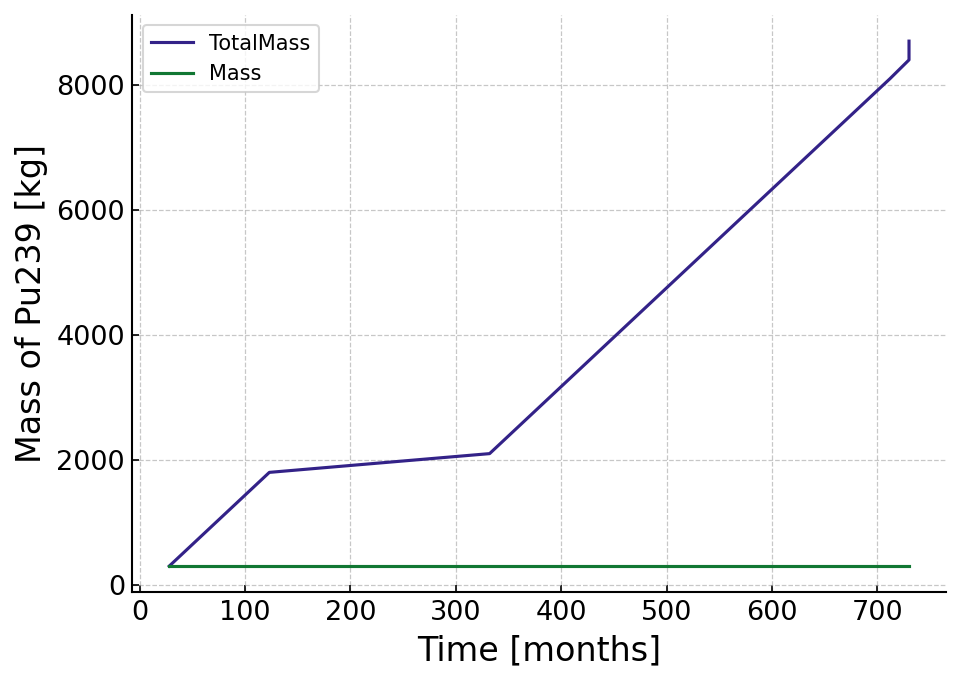

In [20]:
Pu239_mass = waste.transactions_nuc_built_in(evaler,receivers=['Storage'], commodities=['used_uox'], nucs=['94239'])

Pu239_mass['TotalMass'] = Pu239_mass['Mass'].cumsum()
Pu239_mass[['Time','TotalMass','Mass']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of Pu239 [kg]')

# Sqlite Analysis
In this section, I will use basic sqlite to generate plots of the remaining data.

In [21]:
conn = sqlite3.connect('cycamore_me_test_out.sqlite')

In [22]:
cursor = conn.cursor()

In [23]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
columns = cursor.fetchall()

In [24]:
cursor.execute("SELECT * FROM Transactions")
reactinfo_rows = cursor.fetchall()

for row in reactinfo_rows:
    print(row)

(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 0, 23, 26, 15, 'otr_u', 0)
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 1, 22, 24, 17, 'nat_u', 0)
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 2, 23, 26, 32, 'otr_u', 1)
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 3, 22, 24, 34, 'nat_u', 1)
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 4, 23, 26, 49, 'otr_u', 2)
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 5, 22, 24, 51, 'nat_u', 2)
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 6, 23, 26, 66, 'otr_u', 3)
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 7, 22, 24, 68, 'nat_u', 3)
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 8, 23, 26, 83, 'otr_u', 4)
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 9, 22, 24, 85, 'nat_u', 4)
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 10, 23, 26, 100, 'otr_u', 

In [25]:
cursor.execute("SELECT * FROM Info")
info_rows = cursor.fetchall()

for row in info_rows:
    print(row)

# define variables for the start and end of the simulation
start_year = info_rows[0][2]
start_month= info_rows[0][3]
end_month = info_rows[0][4]

(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', '', 2020, 1, 840, 20160212, 10000, b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'init', -1, '1.6.0', '1.6', '3.45.3', '1.14.3-', '1_85', '2.12.7', '-1')


In [26]:
# now we can add the rest of the dates from the simulation info
dates = pd.date_range(start=f'{start_year}-{start_month}-01', periods=end_month, freq='ME')

In [27]:
cursor.execute("SELECT * FROM DecomSchedule")
rows = cursor.fetchall()
for row in rows:
    print(row)

(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 29, 730, 730)


In [28]:
cursor.execute("SELECT * FROM BuildSchedule")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 21, 'Base_Reactor', 0, 10)


## Energy Production

In [29]:
# we will pull the decom schedule to see the ids and decomission date, to id the reactor
cursor.execute("SELECT * FROM DecomSchedule")
decom_rows = cursor.fetchall()

for row in decom_rows:
    print(row)

(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 29, 730, 730)


In [30]:
# now we will pull the supplied power to get the amount of power from each reactor at every time step
cursor.execute("SELECT * FROM TimeSeriessupplyPOWER")
supply_rows = cursor.fetchall()

#for row in supply_rows:
#    print(row)

In [31]:
# create an empty dictionary that mirrors the format of the powersupply table
energy_supply = {
    'id':[],
    'time':[],
    'energy':[]
}

# now we will pull the power at each time step for each reactor
for row in range(len(supply_rows)):
    energy_supply['id'].append(str(supply_rows[row][1]))
    energy_supply['time'].append(supply_rows[row][2])
    energy_supply['energy'].append(supply_rows[row][3])

In [32]:
# make the dictionary into a pandas dataframe to match the type of the other data we've been working with
energy_supply_df = pd.DataFrame.from_dict(energy_supply)

In [33]:
# we will turn the ids into columns of energy and make the index time
switch_energy_supply = energy_supply_df.pivot_table(index='time', columns='id', values='energy', fill_value=0)

# now we will add a total_energy column
switch_energy_supply['total_energy'] = switch_energy_supply.iloc[:,0:].sum(axis=1)

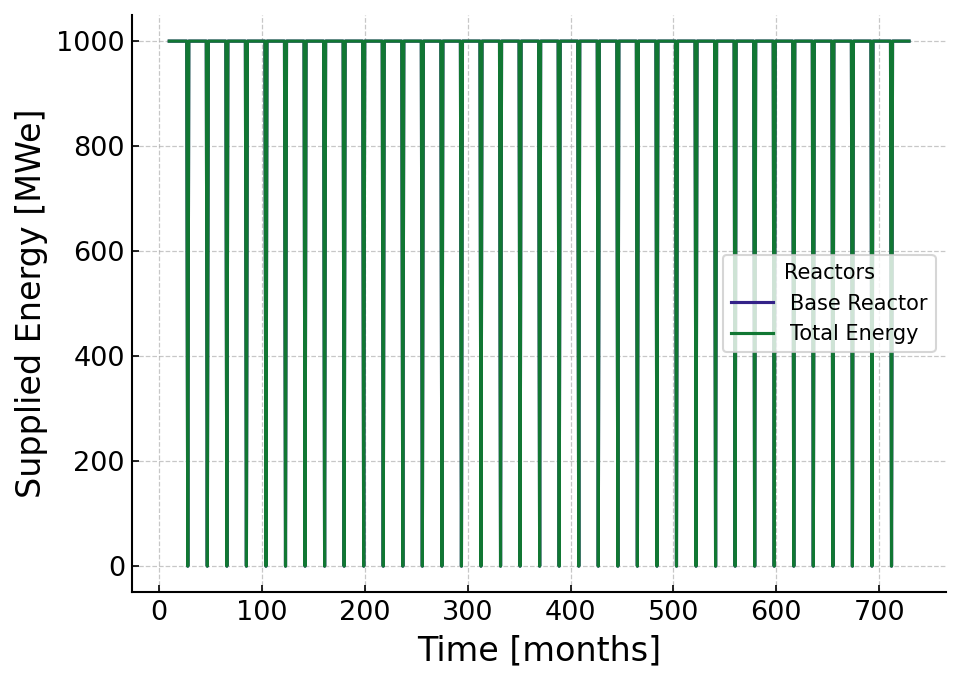

In [34]:
switch_energy_supply[['29','total_energy']].plot()
plt.xlabel('Time [months]')
plt.ylabel('Supplied Energy [MWe]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('Base Reactor')
legend.get_texts()[1].set_text('Total Energy')
legend.set_title('Reactors')

In [35]:
simulation_energy_supply = pd.DataFrame(index=range(start_month,end_month), columns=switch_energy_supply.columns)
simulation_energy_supply = simulation_energy_supply.fillna(0)

for column in switch_energy_supply.columns:
    for time in range(min(switch_energy_supply.index), max(switch_energy_supply.index)):
        simulation_energy_supply.loc[time, column] = switch_energy_supply.loc[time, column]

/tmp/ipykernel_21442/2997257727.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  simulation_energy_supply = simulation_energy_supply.fillna(0)


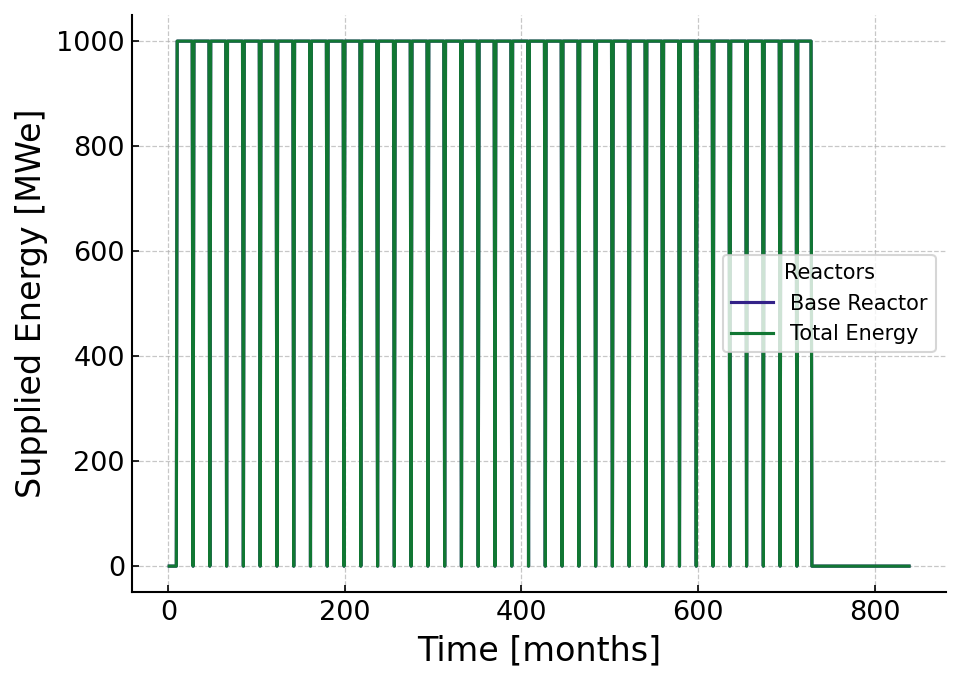

In [36]:
simulation_energy_supply.plot()
plt.xlabel('Time [months]')
plt.ylabel('Supplied Energy [MWe]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('Base Reactor')
legend.get_texts()[1].set_text('Total Energy')
legend.set_title('Reactors')

## SWU

In [37]:
cursor.execute("SELECT * FROM TimeSeriesEnrichmentSWU")
swu_rows = cursor.fetchall()


for row in swu_rows:
   print(row)

(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 24, 0, 4.6850731347659e-310, '')
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 25, 0, 0.0, '')
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 26, 0, 0.0, '')
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 27, 0, 0.0, '')
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 24, 1, 4.6850731347659e-310, '')
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 25, 1, 0.0, '')
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 26, 1, 0.0, '')
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 27, 1, 0.0, '')
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 24, 2, 4.6850731347659e-310, '')
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 25, 2, 0.0, '')
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 26, 2, 0.0, '')
(b'\xdb\xe4\x10\xbey\xcaL\xc2\xbe\xd5\x04\xe0\xf1\x9d\x86\x8d', 27, 2

In [38]:
# create an empty dictionary that mirrors the format of the TimeSeriesEnrichmentSWU table
swu_supply = {
    'id':[],
    'Time':[],
    'SWU':[]
}

# now we will pull the swu at each time step for each facility
for row in range(len(swu_rows)):
    swu_supply['id'].append(str(swu_rows[row][1]))
    swu_supply['Time'].append(swu_rows[row][2])
    swu_supply['SWU'].append(swu_rows[row][3])

# make the dictionary into a pandas dataframe to match the type of the other data we've been working with
swu_supply_df = pd.DataFrame.from_dict(swu_supply)

In [39]:
# we will turn the ids into columns of energy and make the index time
switch_swu_supply = swu_supply_df.pivot_table(index='Time', columns='id', values='SWU', fill_value=0)

# now we will add a total_energy column
switch_swu_supply['total_swu'] = switch_swu_supply.iloc[:,0:].sum(axis=1)

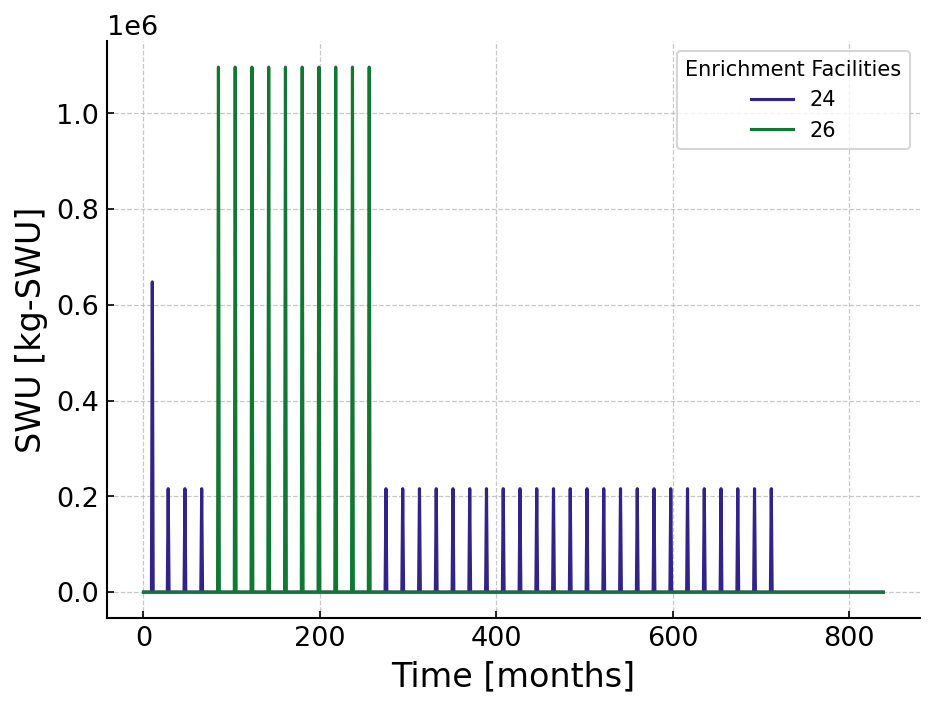

In [40]:
switch_swu_supply[['24','26']].plot()
plt.xlabel('Time [months]')
plt.ylabel('SWU [kg-SWU]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
#legend.get_texts()[0].set_text('id33')
# legend.get_texts()[1].set_text('id35')
# legend.get_texts()[2].set_text('Total SWU')
legend.set_title('Enrichment Facilities')